In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from time import sleep
from random import randint
import pdb
import re
import os
import time
from pathlib import Path
import pickle
import random
from os import system
from copy import deepcopy
from dask import dataframe as dd
from sklearn.metrics import classification_report
import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [2]:
pos = pd.read_csv('./data/possitive_case.csv')
neg = pd.read_csv('./data/negative_case.csv')

In [3]:
neg_columns = ['Unnamed: 0','marketplace','star_rating','helpful_votes','total_votes','verified_purchase','review_headline','review_date','product_title']

In [4]:
neg_reviews_df = neg.drop(columns=neg_columns)

In [5]:
pos['Status'] = 1

In [6]:
pos_reviews_df = pos.drop(columns=neg_columns)

In [7]:
join = [pos_reviews_df,neg_reviews_df]

In [8]:
joined = pd.concat(join)

In [9]:
joined = joined.dropna()

In [10]:
text, status = list(joined['review_body']), list(joined['Status'])


In [11]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

Url_Pattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
User_Pattern = '@[^\s]+'
Alph_Num_Pattern = "[^a-zA-Z0-9]"
Repeat_Pattern = r"(.)\1\1+"
Replace_Pattern = r"\1\1"

def process_words(text):
    processed_text = []
    wordLemm = WordNetLemmatizer()
    for review in text:
        review = re.sub(Alph_Num_Pattern, ' ', review)
        review = review.lower()
        review = re.sub(Url_Pattern, 'Url', review)
        for emoji in emojis.keys():
            review = review.replace(emoji, emojis[emoji])
        review = re.sub(User_Pattern, 'User', review)
        review = re.sub(Repeat_Pattern, Replace_Pattern, review)
        review_words = ''
        for word in review.split():
            if len(word)>1:
                word = wordLemm.lemmatize(word)
                review_words += (word+' ')
                
        processed_text.append(review_words)
    return processed_text
    

In [12]:
t = time.time()
processedtext = process_words(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 458 seconds


In [13]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, status,
                                                    test_size = 0.2, random_state = 0)
print(f'Data Split done.')

Data Split done.


In [14]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=400000)
X_train = vectoriser.fit_transform(X_train)
X_test = vectoriser.transform(X_test)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.
No. of feature_words:  400000


In [15]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.75      0.75      0.75     31484
           1       0.74      0.75      0.74     30777

    accuracy                           0.75     62261
   macro avg       0.75      0.75      0.75     62261
weighted avg       0.75      0.75      0.75     62261



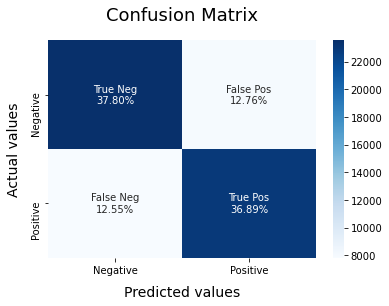

In [16]:
LineSVCmodel = LinearSVC()
LineSVCmodel.fit(X_train, y_train)
model_Evaluate(LineSVCmodel)

In [17]:
LinearSVCParams = {
    'penalty':['l1','l2'],
    'loss':['square','squared_hinge'],
    'C':[1.0,10.0,100.0,1000.0],
    'tol':[1e-5,1e-4,1e-3,1e-2,1e-1]
}

In [20]:

grid_LinearSVC = GridSearchCV(estimator=LinearSVC(),
                    param_grid=LinearSVCParams,
                    scoring='accuracy',
                    verbose=1,
                    n_jobs=-1)

#result_grid_SVC = grid_LinearSVC.fit(X_train, y_train)